In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import polars as pl
import hashlib
sns.set_theme('paper')
sns.set_style('darkgrid')

### Задача 1

Оцените скорость сходимости среднего по выборке из логнормального распределения к нормальному распределению (как предписывает ЦПТ) в зависимости от:

1. Размера выборки
1. Параметров логнормального распределения

### П.1
Для начала оценим сходимость среднего по выборке из логнормального распределения к нормальному визуально в соответствии с ЦПТ в форме Леви для различных размеров выборок и параметров.
$$
\sqrt{n}\frac{\overline{S_n} - E[\xi]}{\sqrt{D[\xi]}} \rightarrow Norm(0, 1)
$$
В качестве параметра для вариации будем использовать только параметр $\sigma$ т.к параметр $\mu$ - в логнормальном распределении отвечает за масштабирование распределения,
Так же будем считать что у нас 100 независимых выборок, в каждой из которых будем варировать число наблюдений.

In [2]:
def normal_to_lognormal(mu, std):
    log_mu = np.exp(mu + 1/2 * (std**2))
    log_std = np.sqrt((np.exp(std ** 2) - 1)*(log_mu**2))
    return [log_mu, log_std]

dist_params = np.array([[0, 1/2], [0, 1], [0, 1.5], [0, 2]])
log_params = np.array([normal_to_lognormal(mu, std) for mu, std in dist_params])
sample_sizes = np.array([10, 100, 1000, 10000, 100000])
x = np.linspace(-5, 5, 1000)
y = stats.norm.pdf(x)

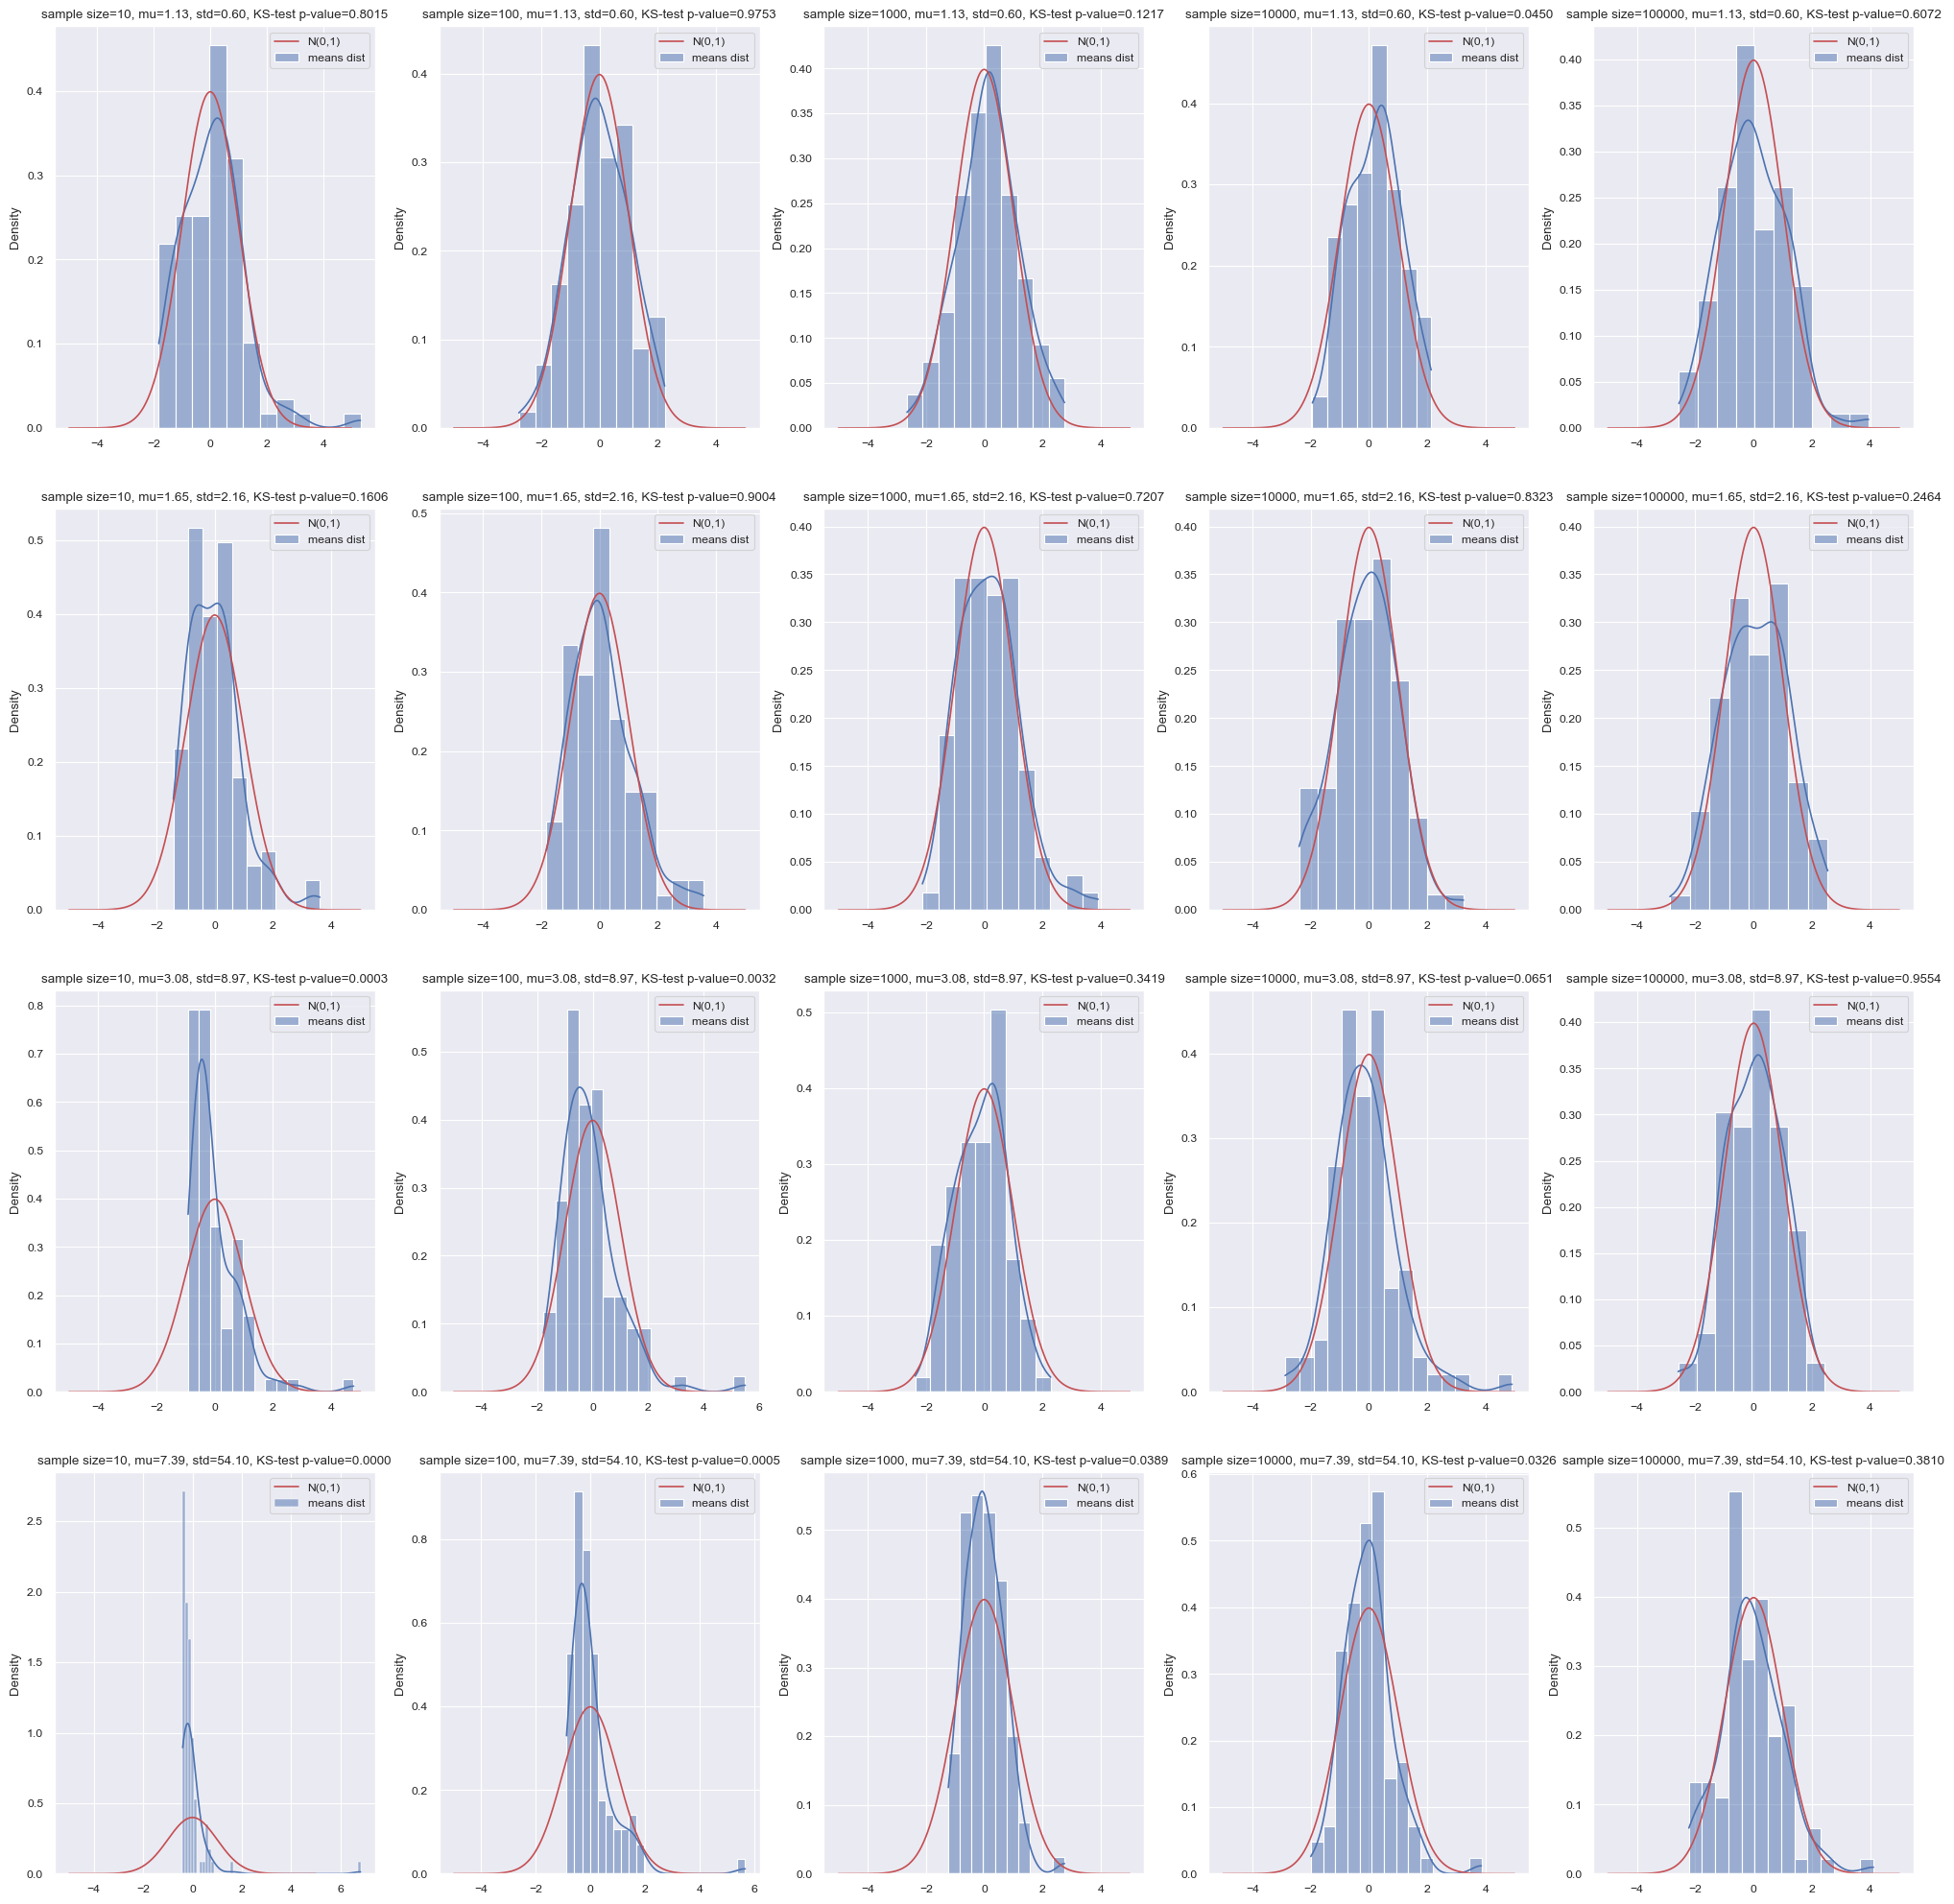

In [3]:
cpt_transform = lambda sample, mu, std: np.sqrt(sample.shape[1]) * (np.mean(sample, axis=1).flatten() - mu) / std
rng = np.random.default_rng(42)
samples = [rng.lognormal(*dp, size=1000 * sample_sizes[-1]) for dp in dist_params]
fig, ax = plt.subplots(len(dist_params), len(sample_sizes), figsize=(25, 25))


for i in range(len(log_params)):
    for j in range(len(sample_sizes)):
        sample = rng.choice(samples[i], size=(100, sample_sizes[j]), replace=True)
        sample = cpt_transform(sample, *log_params[i])
        _, p_value = stats.kstest(sample, stats.norm.cdf)
        sns.histplot(sample, ax=ax[i, j], stat='density', kde=True, label='means dist')
        ax[i, j].plot(x, y, label="N(0,1)", c="r")
        ax[i, j].set_title(f'sample size={sample_sizes[j]}, mu={log_params[i][0]:.2f}, std={log_params[i][1]:.2f}, KS-test p-value={p_value:.4f}')
        ax[i, j].legend()
plt.show()

По графикам с наложенной плотностью N(0,1) видно, что распределение выборочных средних визуально сходится к нормальному, распределению. В качестве подтверждения данное заключение можно получить из значения p-value критерия согласия Колмогорова, где p-value означает вероятность получить такое распределение средних, если гипотеза $H_0$ о равенстве распределений верна.

### П.2

Для большей наглядности визуализируем p-value для большего числа промежуточных размеров выборок. Так же, как меру расстояния между распределения рассмотрим KL-дивергенцию.

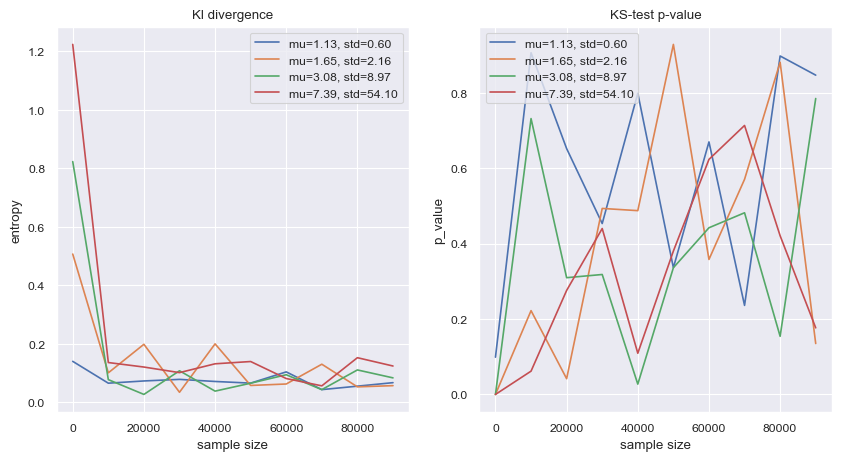

In [4]:
sample_sizes = list(range(1, 100000, 10000))
entropies = []
p_values = []
for i in range(len(log_params)):
    tmp_p_values = []
    tmp_entropies = []
    for j in range(len(sample_sizes)):
        sample = rng.choice(samples[i], size=(100, sample_sizes[j]), replace=True)
        sample = cpt_transform(sample, *log_params[i])
        density, bin_edges = np.histogram(sample, density=True)
        entropy = stats.entropy(density, stats.norm.pdf(bin_edges[:-1]))
        tmp_entropies.append(entropy)
        _, p_value = stats.kstest(sample, stats.norm.cdf)
        tmp_p_values.append(p_value)
    entropies.append(tmp_entropies)
    p_values.append(tmp_p_values)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for ps, es, (mu, std) in zip(p_values, entropies, log_params):
    ax[0].plot(sample_sizes, es, label=f'mu={mu:.2f}, std={std:.2f}')
    ax[1].plot(sample_sizes, ps, label=f'mu={mu:.2f}, std={std:.2f}')

ax[0].set_title('Kl divergence')
ax[0].set_xlabel("sample size")
ax[0].set_ylabel("entropy")
ax[0].legend()
ax[1].set_title('KS-test p-value')
ax[1].set_ylabel('p_value')
ax[1].set_xlabel('sample size')
ax[1].legend()
plt.show()

Как результат, можно видеть, что с ростом числа наблюдений в каждой из выборок растет значение p-value, что не позволяет откинуть гипотезу $H_0$ о том что выборочные срежние ~ Norm(0,1).

Так же по графикам дивергенции модно видеть, что энтропия между распределениями с ростом числа наблюдений стабилизируется.

## Задача 2
Возьмите [данные](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop) с Kaggle и оцените равномерность разбиения их на группы (для будущего АБ-теста) с помощью различных видов хеширования:

md5
sha256
Улучшится ли равномерность, если вместо одинарного использования md5 применить [вот такую](https://towardsdatascience.com/assign-experiment-variants-at-scale-in-a-b-tests-e80fedb2779d) двухуровневую процедуру с тем же md5, проверить на тех же данных.

In [5]:
df = pl.read_csv('archive/2019-*.csv')

In [6]:
df.head()

event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
str,str,i64,i64,str,str,f64,i64,str
"""2019-12-01 00:00:00 UTC""","""remove_from_cart""",5712790,1487580005268456287,null,"""f.o.x""",6.27,576802932,"""51d85cb0-897f-48d2-918b-ad6396…"
"""2019-12-01 00:00:00 UTC""","""view""",5764655,1487580005411062629,null,"""cnd""",29.05,412120092,"""8adff31e-2051-4894-9758-224bfa…"
"""2019-12-01 00:00:02 UTC""","""cart""",4958,1487580009471148064,null,"""runail""",1.19,494077766,"""c99a50e8-2fac-4c4d-89ec-41c05f…"
"""2019-12-01 00:00:05 UTC""","""view""",5848413,1487580007675986893,null,"""freedecor""",0.79,348405118,"""722ffea5-73c0-4924-8e8f-371ff8…"
"""2019-12-01 00:00:07 UTC""","""view""",5824148,1487580005511725929,null,null,5.56,576005683,"""28172809-7e4a-45ce-bab0-5efa90…"


In [7]:
user_ids = df.select('user_id').unique().to_series()
f'{df.shape=}, {df.select('user_id').unique().shape=}'

"df.shape=(12271406, 9), df.select('user_id').unique().shape=(1012561, 1)"

In [8]:
def bucket_distribution(buckets):
    ab_bucket = [sum(buckets[:len(buckets) // 2]), sum(buckets[len(buckets) // 2:])]
    _, ax = plt.subplots(1, 2, figsize=(15, 4))
    barplot = sns.barplot(buckets, ax=ax[0])
    barplot.set_xticks(range(0, 110, 10), range(0, 110, 10))
    sns.barplot(ab_bucket)
    x, bc = stats.chisquare(buckets, [sum(buckets)/len(buckets)] * len(buckets))
    y, abc = stats.chisquare(ab_bucket)
    print(f'100 bucket stat: {x}, 2 bucket stat: {y}')
    ax[0].set_title(f"Buckets dist, Chisquare uniform p-value: {bc:.4f}")
    ax[1].set_title(f'A/B buckets dist, Chisquare uniform p-value: {abc:.4f}')

Для начала попробуем просто разбить всех пользователей на группы по хешу

100 bucket stat: 93.84578213065681, 2 bucket stat: 0.16845306109952882


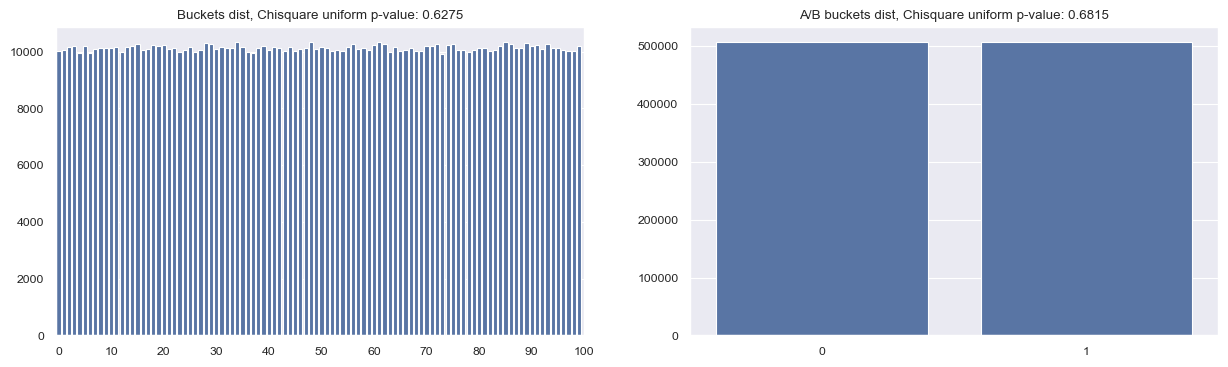

In [9]:
md_buckets = np.array([0] * 100)
def onestep_md5_buckets(to_hash, num_buckets=100):
    return int(hashlib.md5(to_hash.encode()).hexdigest(), 16) % num_buckets

for value in user_ids:
    md_buckets[onestep_md5_buckets(str(value))] += 1
bucket_distribution(md_buckets)

100 bucket stat: 102.68515082054314, 2 bucket stat: 0.46883200123251834


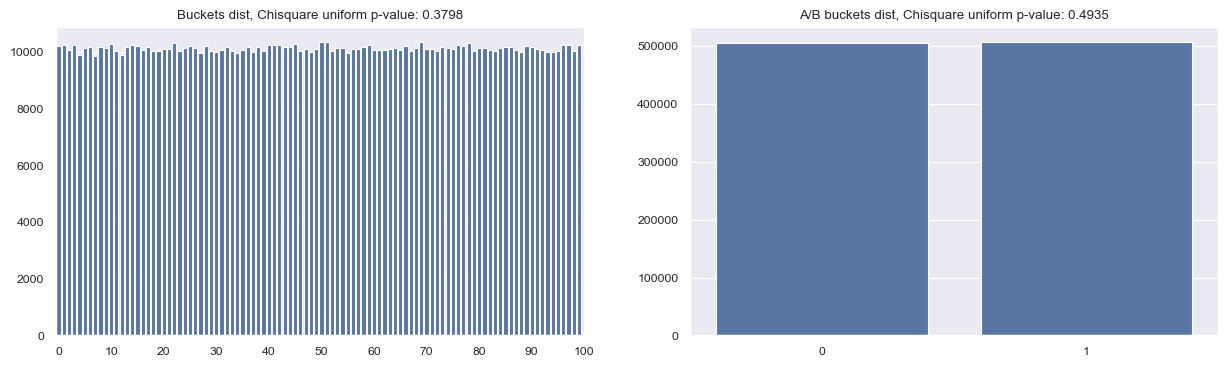

In [10]:
sha_buckets = np.array([0] * 100)
def onestep_sha256_buckets(to_hash, num_buckets=100):
    return int(hashlib.sha256(to_hash.encode()).hexdigest(), 16) % num_buckets

for value in user_ids:
    sha_buckets[onestep_sha256_buckets(str(value))] += 1

bucket_distribution(sha_buckets)

Теперь попробуем смоделировать ситуацию разбиения на A/B тест лишь c частью трафика трафика.

100 bucket stat: 107.35565345370856, 2 bucket stat: 0.015023854443445707


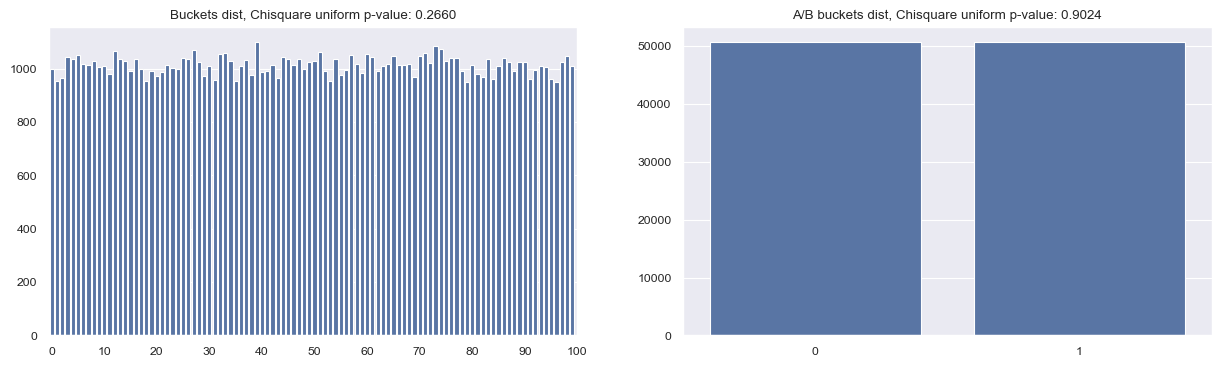

In [11]:
buckets = np.array([0] * 100)

def twostep_md5_buckets(s, threshold=0.1):
    for value in s:
        value = str(value)
        res = onestep_md5_buckets(value + 'pre')
        if res < threshold * 100:
            buckets[onestep_md5_buckets(value + 'bucket')] += 1

twostep_md5_buckets(user_ids)
bucket_distribution(buckets)

100 bucket stat: 93.84937337900176, 2 bucket stat: 1.3116078322675166


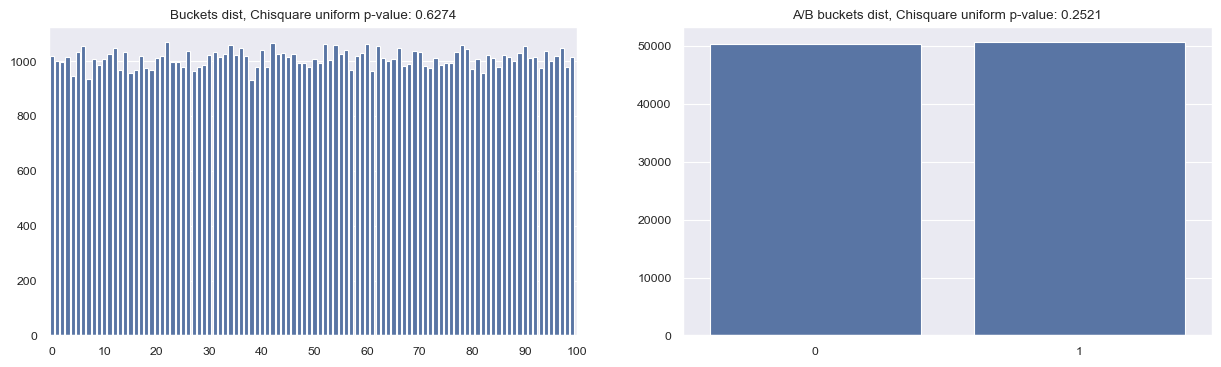

In [12]:
buckets = np.array([0] * 100)

def twostep_sha256_buckets(s, threshold=0.1):
    for value in s:
        value = str(value)
        res = onestep_sha256_buckets(value + 'pre')
        if res < threshold * 100:
            buckets[onestep_sha256_buckets(value + 'bucket')] += 1

twostep_sha256_buckets(user_ids)
bucket_distribution(buckets)

Теперь попробуем улучшшить результаты сделав независимую равномерно распределенную разбивку на каждом шаге

100 bucket stat: 87.73567952077873, 2 bucket stat: 0.01422688131785848


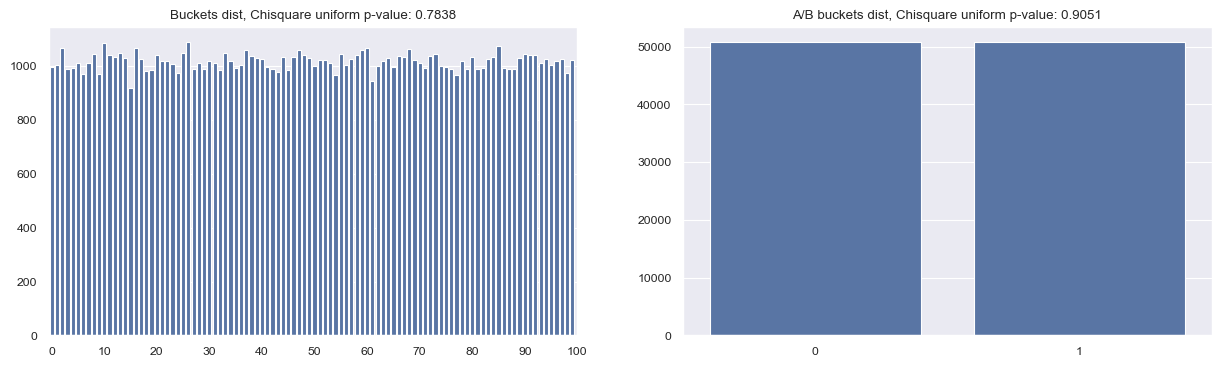

In [13]:
buckets = np.array([0] * 100)

def mod_twostep_md5_buckets(s, threshold=.1):
    for value in s:
        value = str(value)
        res = int(int(hashlib.md5(value.encode()).hexdigest(), 16) / 16**32 * 10000)
        if res / 100 < threshold * 100:
            buckets[res % 100] += 1

mod_twostep_md5_buckets(user_ids)
bucket_distribution(buckets)

100 bucket stat: 57.41201139420795, 2 bucket stat: 0.006686184522867542


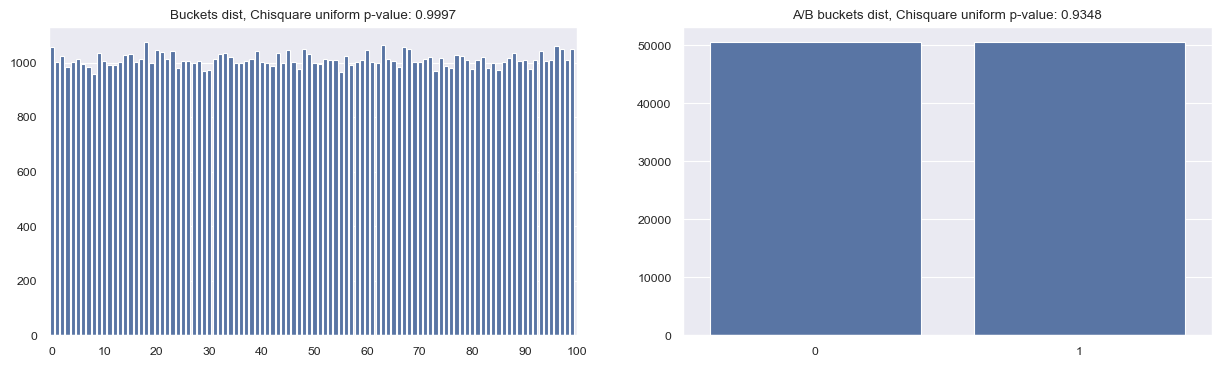

In [14]:


buckets = np.array([0] * 100)

def mod_twostep_sha_buckets(s, threshold=.1):
    for value in s:
        value = str(value)
        res = int(int(hashlib.sha256(value.encode()).hexdigest(), 16) / 16**64 * 10000)
        if res / 100 < threshold * 100:
            buckets[res % 100] += 1

mod_twostep_sha_buckets(user_ids)
bucket_distribution(buckets)

В ходе эксперементов было выявлено, что при разбиении трафика для A/B по хэшу, алгоритм из [статьи](https://towardsdatascience.com/assign-experiment-variants-at-scale-in-a-b-tests-e80fedb2779d) работает лучше, именно при разбиении на 2 группы.

### Задание 3
Напишите функцию для оценки доверительного интервала для параметра в выборке с помощью Пуассоновского бутстрепа. Функция должна принимать на вход выборку и агрегационную функцию, с помощью которой будет вычисляться статистика по выборке, например:

PoissonBootstrap(sample, np.median)
или

PoissonBootstrap(sample, lambda x: np.median(x)/np.mean(x))

In [22]:
def PoissonBootstrap(sample, stat, num_samples=1000, p_value=.05, seed=None):
    stats = []
    rng = np.random.default_rng(seed)
    poiss_weights = rng.poisson(lam=1, size=(num_samples, sample.shape[0]))
    for weight in poiss_weights:
        bootstrap_sample = np.repeat(sample, weight)
        stats.append(stat(bootstrap_sample))
    pe = np.mean(stats)
    lower = np.percentile(stats, (p_value / 2) * 100)
    upper = np.percentile(stats, (1 - (p_value / 2)) * 100)
    return stats, pe, lower, upper

Для тестирования будем использовать аналитические статистики логнормального распределения 

In [23]:
rng = np.random.default_rng(42)
means = []
stds = []
medians = []
means_lower = []
stds_lower = []
medians_lower = []
means_upper = []
stds_upper = []
medians_upper = []
true_medians = []
true_stds = []
true_means = []
for i in range(len(dist_params)):
    sample = rng.lognormal(*dist_params[i], size=(10000))
    true_medians.append(np.exp(dist_params[i][0]))
    true_means.append(log_params[i][0])
    true_stds.append(log_params[i][1])
    _,  pe_mean, lower_mean, upper_mean = PoissonBootstrap(sample, np.mean, num_samples=2000)
    _,  pe_median, lower_median, upper_median = PoissonBootstrap(sample, np.median, num_samples=2000)
    _,  pe_std, lower_std, upper_std = PoissonBootstrap(sample, np.std, num_samples=2000)
    means.append(pe_mean)
    means_lower.append(lower_mean)
    means_upper.append(upper_mean)
    medians.append(pe_median)
    medians_lower.append(lower_median)
    medians_upper.append(upper_median)
    stds.append(pe_std)
    stds_lower.append(lower_std)
    stds_upper.append(upper_std)

In [24]:
data = [true_means, means, means_lower, means_upper, 
    true_medians, medians, medians_lower, medians_upper, 
    true_stds, stds, stds_lower, stds_upper]
data = [np.array(lst, dtype=pl.Float32) for lst in data]
df = pl.DataFrame(data, schema=[
    "Среднее", "Среднее оценка", "mean low", "mean up",
    "Медиана", "Медиана оценка", "med low", "med up",
    "Отклонение", "Отклонение оценка", "std low", "std up",
    ], orient="col")

In [25]:
df

Среднее,Среднее оценка,mean low,mean up,Медиана,Медиана оценка,med low,med up,Отклонение,Отклонение оценка,std low,std up
object,object,object,object,object,object,object,object,object,object,object,object
1.1331484530668263,1.1292040931627838,1.117231601262858,1.1411965306532015,1.0,0.9934378740876264,0.9811469350624292,1.0044759237118086,0.6039005332108811,0.6076241633849976,0.5912413513818998,0.6256407224633619
1.6487212707001282,1.6842479532053722,1.642387538058109,1.7271755953619607,1.0,1.0091302994842395,0.9881802050033912,1.0315448060671666,2.1611974158950877,2.14419715684704,1.9794626693853743,2.369653529038794
3.080216848918031,3.1601138873969736,3.004999746625298,3.320983688830374,1.0,1.0278021087621474,0.9868150723278204,1.062247114954856,8.973817218116451,8.085861102475778,7.0337817932401485,9.26003869030468
7.38905609893065,7.9433309251076585,6.70900304077054,9.563727788167848,1.0,0.9763617841711789,0.9352734189752181,1.021640483391625,54.09583936874059,75.14721349865009,28.664841997962725,115.95418683262166


Заметно, что на выборках с большой дисперсией оценка на стандартное отклонение получается довольно не точной, что требует большее количество семплов

### Задача 4
C помощью численного эксперимента показать, что t-тест над рангами в некотором смысле эквивалентен тесту Манна-Уитни. В качестве пояснения можете использовать материал [Линделёва](https://lindeloev.github.io/tests-as-linear/)

Попробуем для начала проверить это напрямую на тестовом примере

In [19]:
u_1 = rng.uniform(-10, 10, size = 120)
u_2 = rng.uniform(-10, 10, size=50)
ranks = stats.rankdata([*u_1, *u_2])
ranked_u_1 = ranks[:len(u_1)]
ranked_u_2 = ranks[len(u_1):]
_, p_mann = stats.mannwhitneyu(u_1, u_2)
_, p_t = stats.ttest_ind(ranked_u_1, ranked_u_2)
print(f'p-value U-test: {p_mann}, p-value t-test on ranks: {p_t}')

p-value U-test: 0.24146805157173912, p-value t-test on ranks: 0.2419167415757056


Видим что t-test над рангами приближает значения U-testa, попробуем оценить аппроксимацию через модуль разности получаемых p-value

In [20]:
errors = []
dist = rng.lognormal(3, 1, size=10000)
for i in range(5, 100):
    u_1 = rng.choice(dist, size=i, replace=True)
    u_2 = rng.choice(dist, size=i, replace=True)
    ranks = stats.rankdata([*u_1, *u_2])
    ranked_u_1 = ranks[:len(u_1)]
    ranked_u_2 = ranks[len(u_1):]
    _, p_mann = stats.mannwhitneyu(u_1, u_2)
    _, p_t = stats.ttest_ind(ranked_u_1, ranked_u_2)
    errors.append(abs(p_mann - p_t))

<Axes: >

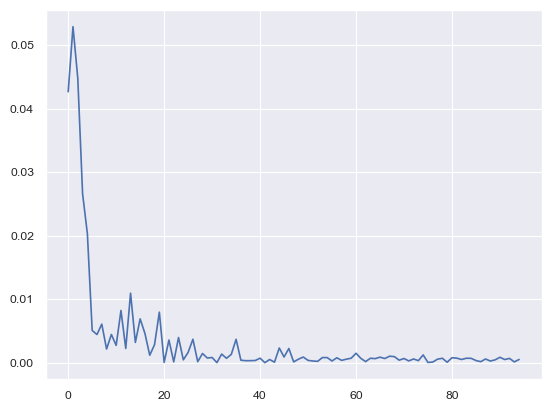

In [21]:
sns.lineplot(errors)

Как видно t-test над рангами очень точно приближает p-value получаемое из критерия Манна-Уитни, начиная с ~ 35 уходя на асимптоту.